In [1]:
import time
import tensorflow as tf
from pathlib import Path
from model import create_model
from dataset import Dataset
import datetime
tf.keras.backend.clear_session()
import numpy as np
for gpu in tf.config.list_physical_devices('GPU'):
    print(gpu)
    tf.config.experimental.set_memory_growth(gpu, True)
#enable XLA
import matplotlib.pyplot as plt  
tf.config.optimizer.set_jit(True)
#enable mixed precision
# from tensorflow.keras.mixed_precision import experimental as mixed_precision
# policy = mixed_precision.Policy('mixed_float16')
# mixed_precision.set_policy(policy)
# print('Compute dtype: %s' % policy.compute_dtype)
# print('Variable dtype: %s' % policy.variable_dtype)



PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [2]:
ds_train, ds_val, class_weight, le, IMAGE_SIZE, N_CLASSES = Dataset.read(batch_size=50)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


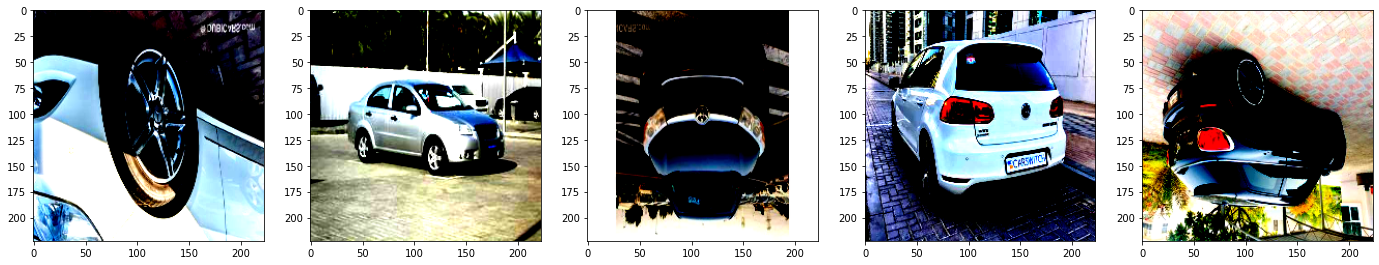

In [3]:
f, ax = plt.subplots(1,5, figsize=(24,6)) 
imgs = [img for img, label in ds_train.unbatch().take(5).as_numpy_iterator()]
for i in range(5):
    ax[i].imshow(imgs[i])

In [4]:
# ds_train, ds_val, train_steps, val_steps, class_weight, N_CLASSES, BATCH_SIZE, IMAGE_SIZE = dataset()

# ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)
# ds_val = ds_val.prefetch(tf.data.experimental.AUTOTUNE)

In [5]:
IMG_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)
OUTPUT_SHAPE = N_CLASSES

Let's check some images

In [ ]:
model_name = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
print(model_name)
log_dir = f"logs/{model_name}"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

In [10]:
checkpoint_dir = Path.cwd() / 'models' / model_name / 'cp{epoch:03d}.ckpt'

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=str(checkpoint_dir),
                                                 save_weights_only=True,
                                                 verbose=0)


In [11]:
# with mirrored_strategy.scope():
lr = 0.0008
model = create_model(IMAGE_SIZE, OUTPUT_SHAPE)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=5)])
model.summary()



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b2 (Model)      (None, 7, 7, 1408)        7768562   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1408)              0         
_________________________________________________________________
dense (Dense)                (None, 894)               1259646   
Total params: 9,028,208
Trainable params: 8,960,640
Non-trainable params: 67,568
_________________________________________________________________


In [12]:
lr_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                                                   patience=3, min_lr=0.0001)

In [16]:
history = model.fit(ds_train,
                    epochs=30,
                    validation_data=ds_val,
#                     workers=1,
                    class_weight=class_weight,
#                     use_multiprocessing=True,
#                     steps_per_epoch=30,
#                      validation_steps=10,
                    callbacks=[tensorboard_callback, 
                               lr_callback, 
                               cp_callback
                              ]
                   )


Epoch 1/30
30/30 [==============================] - 11s 364ms/step - loss: 4.9550 - accuracy: 0.0713 - top_k_categorical_accuracy: 0.1813 - val_loss: 6.9991 - val_accuracy: 0.0020 - val_top_k_categorical_accuracy: 0.0120
Epoch 2/30
13/30 [============>.................] - ETA: 5s - loss: 6.7963 - accuracy: 0.0062 - top_k_categorical_accuracy: 0.0108 

KeyboardInterrupt: 

In [14]:
a=2